In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import matplotlib.pyplot as plt

import theano
import theano.tensor as tt
from theano.tensor import fft

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

# PyMC3 in the Fourier Plane

Let's take a gander at implementing a PyMC3 model to sample a visibility model. For simplicity's sake, we'll keep everything 1D for now. 

$$
    I(\alpha |\, \boldsymbol{\beta}) = a \exp \left [ -  \frac{(\alpha^\prime - \delta_\alpha)^2}{2 \sigma_\alpha^2} \right ]
$$

then the model visibility function (via Fourier transform pairs) is

$$
    V(u |\, \boldsymbol{\beta}) = a e^{- 2 \pi \imath \delta_\alpha u^\prime} \exp \left [ -2 \sigma_\alpha^2 u^{\prime 2} \right ].
$$

Let's implement this sky plane model 

In [18]:
def sky_plane(alpha, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return a * np.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))

In [19]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float64)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

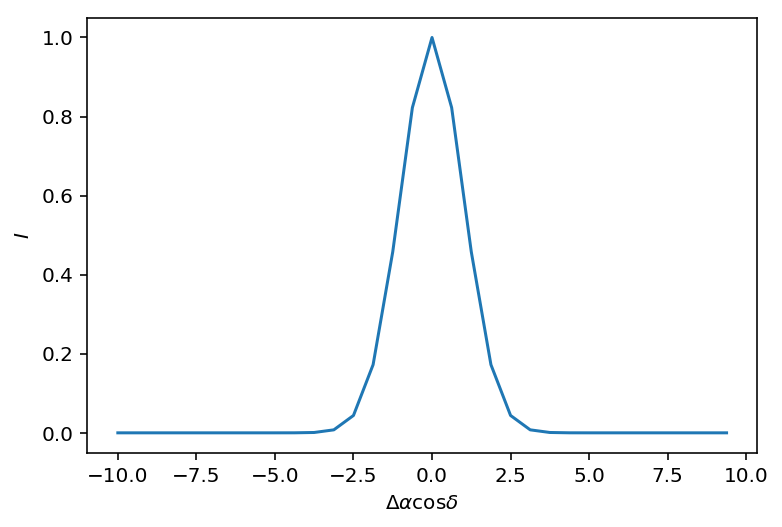

In [20]:
# Let's plot this up and see what it looks like 

N_alpha = 32 
img_radius = 10.0 * arcsec


# full span of the image
ras = fftspace(img_radius, N_alpha) # [arcsec]

# fill out an image 
ys = np.empty(N_alpha, np.float64)

for i,alpha in enumerate(ras):
    ys[i] = sky_plane(alpha)

plt.plot(ras/arcsec, ys)
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$I$");

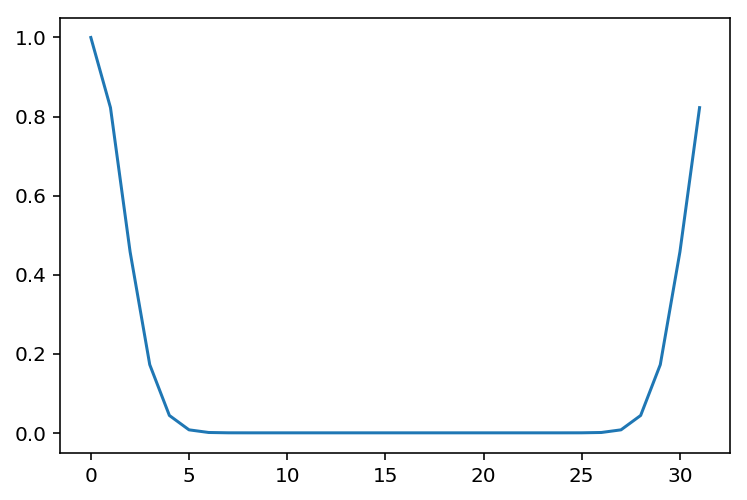

In [21]:
plt.plot(np.fft.fftshift(ys))

In [22]:
vis = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(ys)))
freqs = np.fft.ifftshift(np.fft.fftfreq(N_alpha, img_radius/(N_alpha)))

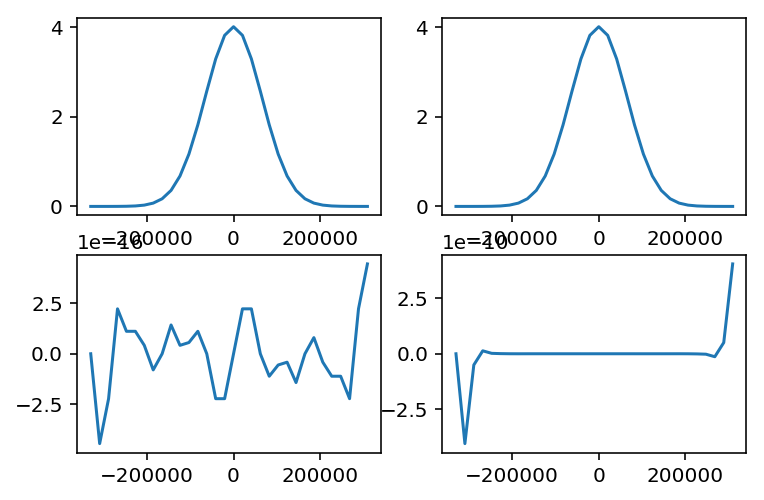

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[1,0].plot(freqs, np.imag(vis))

ax[0,1].plot(freqs, np.abs(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))

In [24]:
noise = 0.1 # Jy

In [25]:
np.random.seed(42)

# create a dataset off of this, by adding noise to the real and imaginary parts
# i.e., we need two noise draws
data = vis + np.random.normal(loc=0, scale=noise, size=(N_alpha)) + \
    np.random.normal(loc=0, scale=noise, size=(N_alpha)) * 1.0j 

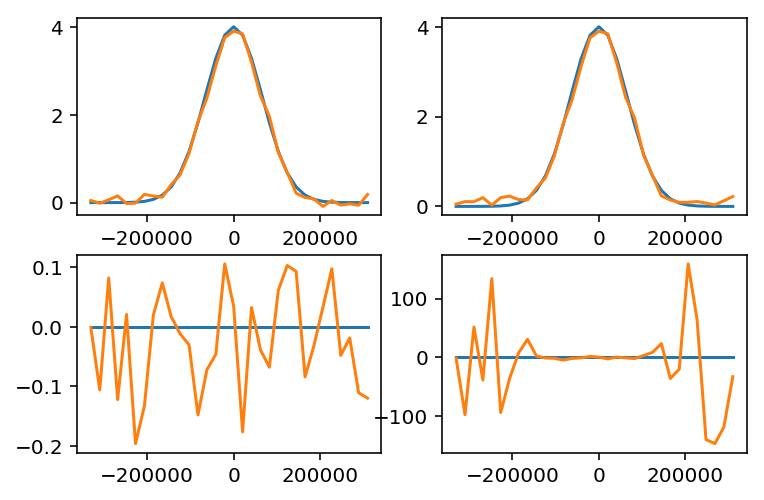

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[0,0].plot(freqs, np.real(data))

ax[1,0].plot(freqs, np.imag(vis))
ax[1,0].plot(freqs, np.imag(data))

ax[0,1].plot(freqs, np.abs(vis))
ax[0,1].plot(freqs, np.abs(data))

ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(data))

# Implementing this model in Theano

Now that we have a dataset, let's implement the necessary calculations in Theano. 

The most challenging part is probably figuring out how to correctly stuff the `fft` http://deeplearning.net/software/theano/library/tensor/fft.html

In [93]:
# Implement the sky-plane model in Theano

# a : amplitude
# delta_alpha : offset (in radians)
# sigma_alpha : width (in radians)

# create imput alphas 
alpha = tt.matrix("alpha")
a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
sigma_alpha = tt.scalar("sigma_alpha")

I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))

sky_model = theano.function([alpha, a, delta_alpha, sigma_alpha], I)    

In [21]:
x = T.dmatrix('x')
s = T.sum(1 / (1 + T.exp(-x)))
gs = T.grad(s, x)

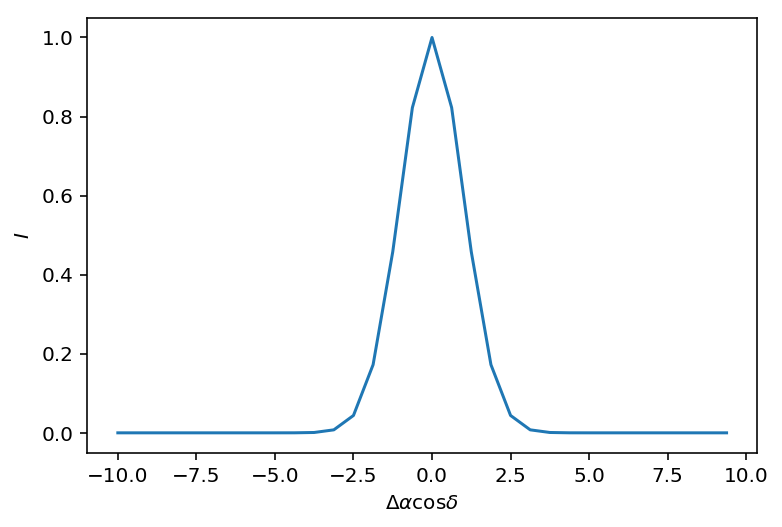

In [96]:
# Let's plot this up and see what it looks like 
N_alpha = 32 
img_radius = 10.0 * arcsec

# full span of the image
ras = fftspace(img_radius, N_alpha) # [arcsec]

# fill out an image 
ys = sky_model(ras[np.newaxis,:], 1, 0.0, 1.0*arcsec)

plt.plot(ras/arcsec, ys[0])
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$I$");

In [36]:
tt.grad(I[0], delta_alpha)

InplaceDimShuffle{}.0

Awesome! Let's try getting the derivative of this model using Theano. How about derivative w.r.t. a, delta_alpha, and sigma_alpha?

In [41]:
J, updates = theano.scan(lambda i, I, delta_alpha : tt.grad(I[i], delta_alpha), \
                         sequences=tt.arange(I.shape[0]), non_sequences=[I, delta_alpha])

f = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

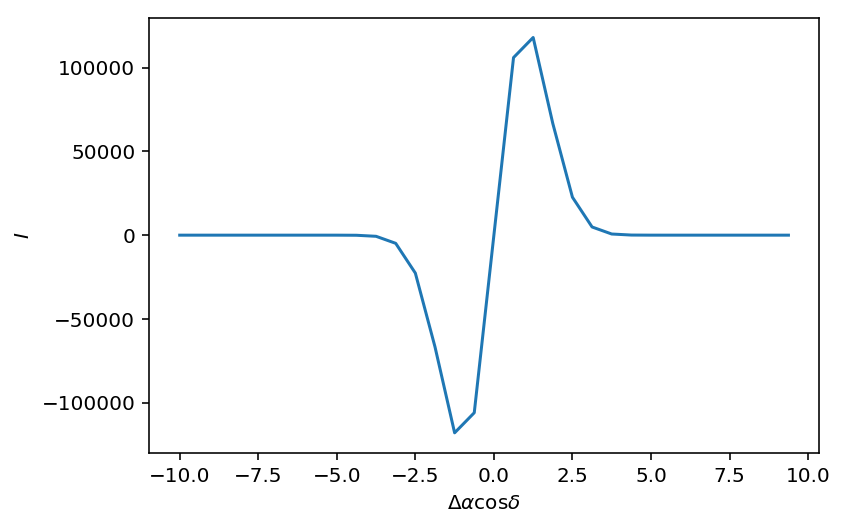

In [42]:
# fill out an image 
dys = f(ras, 1, 0.0, 1.0*arcsec)

plt.plot(ras/arcsec, dys)
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$I$");

In [14]:
def rfft_to_full(rfft_out):
    '''
    Take Theano rfft output (corresponding only to positive spatial frequencies) and duplicate it such that we 
    would have output corresponding to all frequencies.
    '''
    
    # 1D example 
    N = len(rfft_out)
    N_out = 2 * (N - 1)
    c_out = np.empty(N_out, dtype=np.complex128)
    
    c_out[N-1:] = rfft_out[:-1]
    c_out[:N-1] = np.conj(rfft_out[1:])[::-1] # could allocate the conj directly to array

    return c_out

In [84]:
# define the Theano operation
x = tt.matrix('x', dtype='float64')
rfft = fft.rfft(x, norm=None)

# take the output from rfft and expand it to the full-frequencies
# Assume x has length N
# the full-length vector will have size 2 * (N - 1)

c_pos = rfft[0, :-1, :]

# define the complex conjugate manually, by operating independently on the 
# real and negative components
c_neg_real = rfft[0,1:, 0][::-1]
c_neg_imag = -1.0 * rfft[0,1:, 1][::-1]

# assemble this back into a (N/2, 2) matrix
c_neg = tt.stack([c_neg_real, c_neg_imag], axis=1)

# combine the negative and postive chunks to make an (N, 2) output 
c_out = tt.concatenate([c_neg, c_pos], axis=0)

f_rfft = theano.function([x], c_out)

In [105]:
# Implement the full sky-to-visibility model in Theano

# a : amplitude
# delta_alpha : offset (in radians)
# sigma_alpha : width (in radians)

# create input alphas 
# NOTE that these must be `fftshifted` already.
alpha = tt.matrix("alpha")
a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
sigma_alpha = tt.scalar("sigma_alpha")

I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))
# since the input coordinates were already shifted, then this is too

rfft = fft.rfft(I, norm=None)

# take the output from rfft and expand it to the full-frequencies
# Assume x has length N
# the full-length vector will have size 2 * (N - 1)

c_pos = rfft[0, :-1, :]

# define the complex conjugate manually, by operating independently on the 
# real and negative components
c_neg_real = rfft[0,1:, 0][::-1]
c_neg_imag = -1.0 * rfft[0,1:, 1][::-1]

# assemble this back into a (N/2, 2) matrix
c_neg = tt.stack([c_neg_real, c_neg_imag], axis=1)

# combine the negative and postive chunks to make an (N, 2) output 
c_out = tt.concatenate([c_neg, c_pos], axis=0)

f_vis = theano.function([alpha, a, delta_alpha, sigma_alpha], c_out)

Gradients of this function. As far as I can (http://www1.spms.ntu.edu.sg/~ydchong/teaching/06_complex_derivatives.pdf) the derivative of a function that takes real-valued inputs (as ours does) is equal to the derivative of the reals plus the derivative of the imaginaries, i.e., it's ok to treat them separately. So, let's try doing that here.

In [109]:
J, updates = theano.scan(lambda i, c, delta_alpha : tt.grad(c[i], delta_alpha), \
                         sequences=tt.arange(c_out.shape[0]), non_sequences=[c_out[:,0], delta_alpha])

f_reals = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [110]:
f_reals(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([ 1.45519152e-11,  4.36557457e-11, -4.36557457e-11, -1.45519152e-11,
       -1.45519152e-11,  7.27595761e-12,  2.91038305e-11,  7.27595761e-12,
        0.00000000e+00, -7.27595761e-12, -4.36557457e-11,  0.00000000e+00,
        1.45519152e-11,  2.91038305e-11, -1.45519152e-11,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.45519152e-11,  2.91038305e-11,
        1.45519152e-11,  0.00000000e+00, -4.36557457e-11, -7.27595761e-12,
        0.00000000e+00,  7.27595761e-12,  2.91038305e-11,  7.27595761e-12,
       -1.45519152e-11, -1.45519152e-11, -4.36557457e-11,  4.36557457e-11])

In [111]:
J, updates = theano.scan(lambda i, c, delta_alpha : tt.grad(c[i], delta_alpha), \
                         sequences=tt.arange(c_out.shape[0]), non_sequences=[c_out[:,1], delta_alpha])

f_imags = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [112]:
f_imags(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([ 0.00000000e+00,  5.58899226e+01,  2.28725625e+02,  8.06758598e+02,
        2.55750918e+03,  7.29385426e+03,  1.86907854e+04,  4.29605632e+04,
        8.83596926e+04,  1.62082398e+05,  2.63875775e+05,  3.78412597e+05,
        4.71997541e+05,  5.00059883e+05,  4.26666577e+05,  2.47373600e+05,
        0.00000000e+00, -2.47373600e+05, -4.26666577e+05, -5.00059883e+05,
       -4.71997541e+05, -3.78412597e+05, -2.63875775e+05, -1.62082398e+05,
       -8.83596926e+04, -4.29605632e+04, -1.86907854e+04, -7.29385426e+03,
       -2.55750918e+03, -8.06758598e+02, -2.28725625e+02, -5.58899226e+01])

In [102]:
# fill out an image 
vis = f_vis(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

In [103]:
vis

array([[ 2.61671882e-05, -0.00000000e+00],
       [ 6.29769344e-05, -4.44089210e-16],
       [ 2.53165886e-04, -2.22044605e-16],
       [ 9.57871618e-04,  2.22044605e-16],
       [ 3.28900647e-03,  1.11022302e-16],
       [ 1.02326841e-02,  1.11022302e-16],
       [ 2.88438052e-02,  4.16333634e-17],
       [ 7.36635172e-02, -7.97972799e-17],
       [ 1.70446938e-01, -0.00000000e+00],
       [ 3.57324511e-01,  1.42247325e-16],
       [ 6.78692837e-01,  4.16333634e-17],
       [ 1.16794012e+00,  5.55111512e-17],
       [ 1.82097817e+00,  1.11022302e-16],
       [ 2.57232450e+00, -0.00000000e+00],
       [ 3.29218038e+00, -2.22044605e-16],
       [ 3.81749382e+00, -2.22044605e-16],
       [ 4.01060524e+00,  0.00000000e+00],
       [ 3.81749382e+00,  2.22044605e-16],
       [ 3.29218038e+00,  2.22044605e-16],
       [ 2.57232450e+00,  0.00000000e+00],
       [ 1.82097817e+00, -1.11022302e-16],
       [ 1.16794012e+00, -5.55111512e-17],
       [ 6.78692837e-01, -4.16333634e-17],
       [ 3.

In [86]:
box = np.zeros((1, N_alpha), dtype=np.float64) # shape (1, 32) because that's what Theano requires
box[:] = np.fft.fftshift(ys)

# print(fshape(box))
c_full = f_rfft(box)

In [87]:
c_full

array([[ 2.61671882e-05, -0.00000000e+00],
       [ 6.29769344e-05, -4.44089210e-16],
       [ 2.53165886e-04, -2.22044605e-16],
       [ 9.57871618e-04,  2.22044605e-16],
       [ 3.28900647e-03,  1.11022302e-16],
       [ 1.02326841e-02,  1.11022302e-16],
       [ 2.88438052e-02,  4.16333634e-17],
       [ 7.36635172e-02, -7.97972799e-17],
       [ 1.70446938e-01, -0.00000000e+00],
       [ 3.57324511e-01,  1.42247325e-16],
       [ 6.78692837e-01,  4.16333634e-17],
       [ 1.16794012e+00,  5.55111512e-17],
       [ 1.82097817e+00,  1.11022302e-16],
       [ 2.57232450e+00, -0.00000000e+00],
       [ 3.29218038e+00, -2.22044605e-16],
       [ 3.81749382e+00, -2.22044605e-16],
       [ 4.01060524e+00,  0.00000000e+00],
       [ 3.81749382e+00,  2.22044605e-16],
       [ 3.29218038e+00,  2.22044605e-16],
       [ 2.57232450e+00,  0.00000000e+00],
       [ 1.82097817e+00, -1.11022302e-16],
       [ 1.16794012e+00, -5.55111512e-17],
       [ 6.78692837e-01, -4.16333634e-17],
       [ 3.

In [65]:
# from DiskJockey implementation, might be irrelevant if we use the `norm` rfft keyword for Theano
#    # We also want to normalize the result by the input array spacings, so that they are directly comparable with
#    # the analytic transforms (Numerical Recipes ed. 3, Press, Eqn 12.1.6)
#    out = dl * dm * rfft(fftshift(data))
#    return RawModelVis(lam, uu, vv, out)

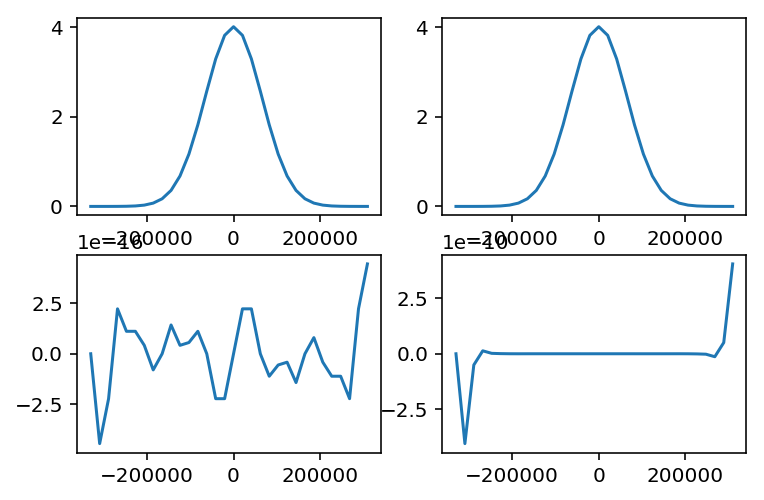

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, vis[:,0])
ax[1,0].plot(freqs, vis[:,1])

ax[0,1].plot(freqs, np.sqrt(c_full[:,0]**2 + c_full[:,1]**2))
ax[1,1].plot(freqs, 180 / np.pi * np.arctan2(c_full[:,1], c_full[:,0]))

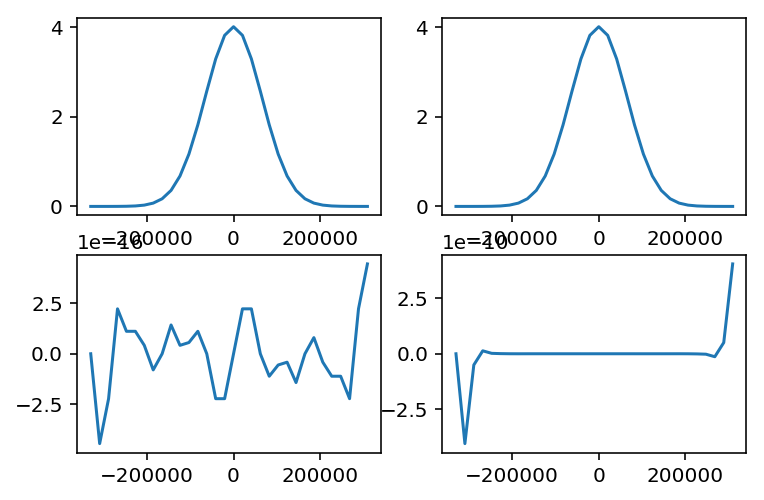

In [90]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, c_full[:,0])
ax[1,0].plot(freqs, c_full[:,1])

ax[0,1].plot(freqs, np.sqrt(c_full[:,0]**2 + c_full[:,1]**2))
ax[1,1].plot(freqs, 180 / np.pi * np.arctan2(c_full[:,1], c_full[:,0]))

Great, it looks like we have everything properly hooked up to the 1D FFT in Theano. Now we'll try inferring the two parameters of our model $\delta_\alpha$ and $\sigma_\alpha$, the position and width of the Gaussian. 

In [ ]:
import theano.tensor as tt
import pymc3 as pm

with pm.Model() as model:

    # Parameters
    delta_alpha = pm.Uniform("delta_alpha", lower=-1*arcsec, upper=1*arcsec)
    sigma_alpha = pm.Uniform("sigma_alpha", lower=0.5*arcsec, upper=1.5*arcsec)
    
    # sky model 
    sky_model = pm.Deterministic("sky_model", tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2)))
    
    # compute the visibility model
    # define the Theano operation
    x = tt.matrix('x', dtype='float64')

    rfft = fft.rfft(x, norm=None)
    f_rfft = theano.function([x], rfft)

    # put in our Gaussian function, appropriately packed 
    box = np.zeros((1, N_alpha), dtype=np.float64) # shape (1, 32) because that's what Theano requires
    box[:] = np.fft.fftshift(sky_model)

    out = f_rfft(box)
    # out has dimensions of (1, N_alpha/2 + 1,2)

    c_out = np.asarray(out[0, :, 0] + 1j*out[0, :, 1]) # Assemble this into a numpy array of complex numbers

    # for the real fft (with real-valued input), the negative frequency terms are just the complex conjugates
    # of the positive frequency terms. So, we should reconstruct these into a single array.
    rfreqs = np.fft.rfftfreq(N_alpha, img_radius/(N_alpha))

    vis_model = rfft_to_full(c_out)                    
                                 
    # condition on observations
    pm.Normal("obs", mu=vis_model, sd=noise, observed=data)